In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from scipy.stats import zscore
import seaborn as sns


from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, TargetEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import optuna
import optuna.visualization as vis
import plotly

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# User Input Fields
train_input_file = "./Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv"
train_labels_file = "./Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv"
test_input_file = "./Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv"
numerical_preprocessing = "StandardScaler"
#numerical_preprocessing = "None"
#categorical_preprocessing = "OneHotEncoder"
categorical_preprocessing = "OrdinalEncoder"
#categorical_preprocessing = "TargetEncoder"

# Possible models: LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier and MLPClassifier.
model_type = "LogisticRegression"
test_prediction_output_file = ""


# Setup fields 
train_pct = 0.8

In [5]:
# Import data from specificed locations

train_values = pd.read_csv(train_input_file)
train_labels = pd.read_csv(train_labels_file)
test_values = pd.read_csv(test_input_file)

numeric_cols = train_values.select_dtypes(include=["int64", "float64"], exclude=["object"]).drop(columns=["id"]).columns
categoric_cols = train_values.select_dtypes(include=["object"], exclude=["int64", "float64"]).columns



In [6]:
# Merging the training values and labels into one dataframe
# train_data = pd.merge(train_values, train_labels, on ='id')
# display(train_data)

# Data Exploration

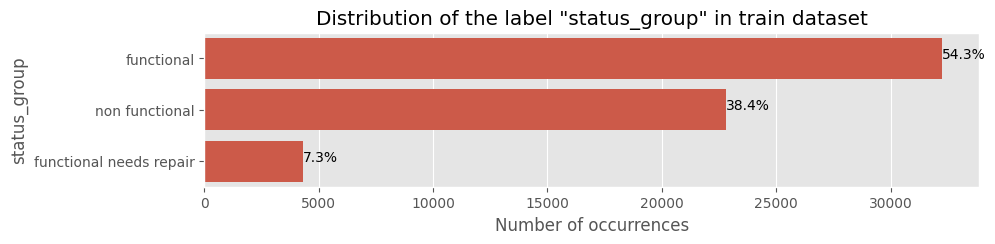

In [7]:
plt.figure(figsize=(10,2))
ax = sns.countplot(y="status_group", data=train_labels)
plt.title('Distribution of the label "status_group" in train dataset')
plt.xlabel('Number of occurrences')
total = len(train_labels)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
plt.show()

In [8]:
# Exploration of data

# Training and test sample count
n_train_samples = len(train_values.index) 
print(f"# Training samples: {n_train_samples}")
n_test_samples = len(test_values.index)
print(f"# Test samples: {n_test_samples}")
print("Number of training samples and labels are equal: " , n_train_samples == len(train_labels))

# Feature count for training data
input_features = train_values.columns
n_features = len(input_features)
print(f"\n# Training features: {n_features}")
print(input_features)

# Label count: unique status_group values in train_labels_file
output_classes = train_labels["status_group"].unique()
print(f"\n# Output classes: {len(output_classes)}")
print(output_classes)


# Training samples: 59400
# Test samples: 14850
Number of training samples and labels are equal:  True

# Training features: 40
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

# Output classes: 3
['functional' 'non functional' 'functional needs repair']


In [9]:
#train_values.head()
#train_values.columns
train_values.describe(include = "all")
# train_values.dtypes
# train_values.shape


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,59400.000000,59400.000000,59400,55763,59400.000000,55745,59400.000000,5.940000e+04,59398,59400.000000,59400,59029,59400,59400.000000,59400.000000,59400,59400,59400.000000,56066,59400,55522,30590,56344,59400.000000,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,NaN,NaN,356,1896,NaN,2145,NaN,NaN,37399,NaN,9,19287,21,NaN,NaN,125,2092,NaN,2,1,11,2695,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,NaN,NaN,2011-03-15,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Lake Victoria,Madukani,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,K,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,NaN,NaN,572,9084,NaN,17402,NaN,NaN,3563,NaN,10248,508,5294,NaN,NaN,2503,307,NaN,51011,59400,36793,682,38852,NaN,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625
mean,37115.131768,317.650385,NaN,NaN,668.297239,NaN,34.077427,-5.706033e+00,NaN,0.474141,NaN,NaN,NaN,15.297003,5.629747,NaN,NaN,179.909983,NaN,NaN,NaN,NaN,NaN,1300.652475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,21453.128371,2997.574558,NaN,NaN,693.116350,NaN,6.567432,2.946019e+00,NaN,12.236230,NaN,NaN,NaN,17.587406,9.633649,NaN,NaN,471.482176,NaN,NaN,NaN,NaN,NaN,951.620547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,NaN,NaN,-90.000000,NaN,0.000000,-1.164944e+01,NaN,0.000000,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,18519.750000,0.000000,NaN,NaN,0.000000,NaN,33.090347,-8.540621e+00,NaN,0.000000,NaN,NaN,NaN,5.000000,2.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,37061.500000,0.000000,NaN,NaN,369.000000,NaN,34.908743,-5.021597e+00,NaN,0.000000,NaN,NaN,NaN,12.000000,3.000000,NaN,NaN,25.000000,NaN,NaN,NaN,NaN,NaN,1986.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,55656.500000,20.000000,NaN,NaN,1319.250000,NaN,37.178387,-3.326156e+00,NaN,0.000000,NaN,NaN,NaN,17.000000,5.000000,NaN,NaN,215.000000,NaN,NaN,NaN,NaN,NaN,2004.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Find NaN values for each of the columns
for name, values in train_values.items():
    nan_count = train_values[name].isna().sum()
    print(name + ": " + str(nan_count))


#Did not find any Nan values in numerical features, only in categorical features 
# All missing values are in categorical features, so we can handle the  
# missing values as an additional category when encoding them

id: 0
amount_tsh: 0
date_recorded: 0
funder: 3637
gps_height: 0
installer: 3655
longitude: 0
latitude: 0
wpt_name: 2
num_private: 0
basin: 0
subvillage: 371
region: 0
region_code: 0
district_code: 0
lga: 0
ward: 0
population: 0
public_meeting: 3334
recorded_by: 0
scheme_management: 3878
scheme_name: 28810
permit: 3056
construction_year: 0
extraction_type: 0
extraction_type_group: 0
extraction_type_class: 0
management: 0
management_group: 0
payment: 0
payment_type: 0
water_quality: 0
quality_group: 0
quantity: 0
quantity_group: 0
source: 0
source_type: 0
source_class: 0
waterpoint_type: 0
waterpoint_type_group: 0


In [11]:
# Find possible categories for a given feature
# featurename = "funder"
# train_values.value_counts(subset= featurename, dropna=False)

### Data Exploration: Categorical features

['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']



In [12]:
# date_recorded
# this feature is read as strings by the dataframe. Therefore, by default, they'll be treated as categorical features. But that doesn't really make sense.
# It will be preprocessed and transformed into a numerical features 

In [13]:
# funder
var = "funder"
print("The " + var + " variable has " + str(len(train_values.funder.unique())) + " unique categories including NaN.")
# Find possible categories 
print(train_values.value_counts(subset = var, dropna=False))
# If category count is too large: 
train_values.value_counts(subset=var, dropna= False).sort_index(ascending=False).to_csv("output.csv")
# Missing values percentage
percentage_fu=round(train_values[var].isnull().sum()/len(train_values)*100,2)
print("The percentage of missing values in "+ var +" is: " + str(percentage_fu) + "%")

# funder conclusions: 
# We have categories 0 and NaN which are to be considered as missing values 
# We have high volume of low occurrence categories, which can be combined into 'other' category

The funder variable has 1897 unique categories including NaN.
funder
Government Of Tanzania          9084
NaN                             3637
Danida                          3114
Hesawa                          2202
Rwssp                           1374
                                ... 
Mwalimu  Maneromango Muhenzi       1
Mwakifuna                          1
Mwakalinga                         1
Mwakabalula                        1
Mganga                             1
Name: count, Length: 1897, dtype: int64
The percentage of missing values in funder is: 6.12%


In [14]:
# installer
var = "installer"
print("The " + var + " variable has " + str(len(train_values.funder.unique())) + " unique categories including NaN.")
# Find possible categories 
print(train_values.value_counts(subset = var, dropna=False))
# If category count is too large: 
# train_values.value_counts(subset=var, dropna= False).sort_index(ascending=False).to_csv("output.csv")
train_values.value_counts(subset=var, dropna= False).sort_values(ascending=False).to_csv("output.csv")
# Missing values percentage
percentage_fu=round(train_values[var].isnull().sum()/len(train_values)*100,2)
print("The percentage of missing values in "+ var +" is: " + str(percentage_fu) + "%")


# installer observations
# Categories to be treated as missing data: 0, "-"


The installer variable has 1897 unique categories including NaN.
installer
DWE                       17402
NaN                        3655
Government                 1825
RWE                        1206
Commu                      1060
                          ...  
LUWASSA                       1
Prima                         1
Primo                         1
Eastmeru medium School        1
Magoma ADP                    1
Name: count, Length: 2146, dtype: int64
The percentage of missing values in installer is: 6.15%


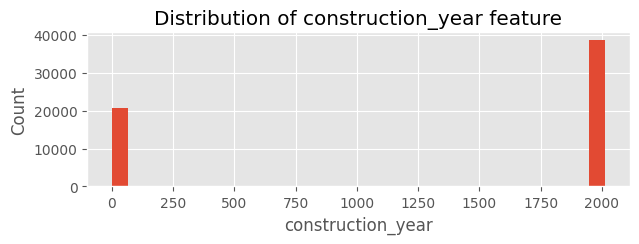

The percentage of rows with 0 in construction_year is: 34.86%.


In [15]:
# Visualisation of numerical features

# Identify features that are numerical
df_num = train_values.select_dtypes(include=["float64", "int64"], exclude=["object"]).drop(columns=["id"])


# construction_year numerical feature
# Construction year = 0 means missing data
plt.figure(figsize=(7,2))
plt.title('Distribution of construction_year feature')
plt.xlabel('construction_year')
plt.ylabel('Count')
feature = "construction_year"
vals = df_num[feature].values # this line takes all values of construction_year column, and put them into a 1-d array
plt.hist(x=vals, bins=30) # show a histogram of the values
plt.show()

percentage = round(((train_values["construction_year"]==0).sum()/len(train_values["construction_year"]!=0)*100),2)
print("The percentage of rows with 0 in construction_year is: " + str(percentage) + "%.")

	
# The percentage of rows with 0 for construction_year is 34.86% so i can get rid of the rows with missing data



    
    

<Figure size 1200x300 with 0 Axes>

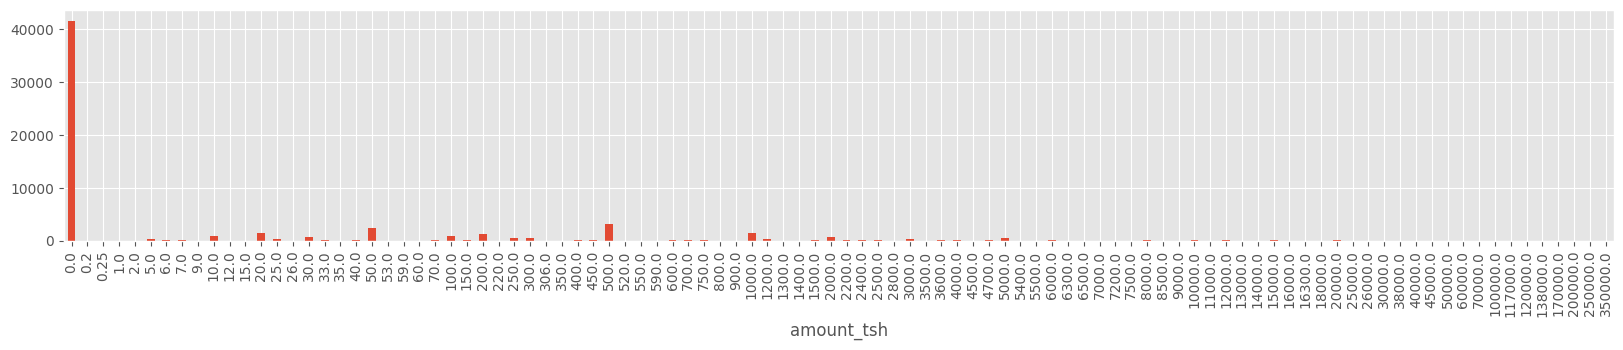

The percentage of rows with 0 in amount_tsh is: 70.1%.


In [16]:
# amount_tsh numerical feature
# TODO Might need to handle some outlier data
# TODO Plot the rest of the numeric features using a loop 
# feature = "amount_tsh"
# plt.hist(df_num[feature], log= True)
# plt.show()

plt.figure(figsize=(12,3))
fig, ax = plt.subplots(figsize=(20,3))
train_values.groupby('amount_tsh').count()['id'].plot(kind="bar",ax=ax)
plt.show()

percentage = round(((train_values["amount_tsh"]==0).sum()/len(train_values["amount_tsh"]!=0)*100),2)
print("The percentage of rows with 0 in amount_tsh is: " + str(percentage) + "%.")

# We assume 0 values in amount_tsh mean that the data is missing
# The percentage of rows with missing data for amount_tsh is 70.1% 
# So we could remove the feature or impute the missing rows

# for f in df_num:
#     print(f)
#     plt.hist(df_num[f])
#     plt.show()

# Assumming the negative values for gps_height are correct as we are dealing with wells 

In [17]:
# # Convert 'date_recorded' to datetime
# train_values["date_recorded"] = pd.to_datetime(train_values["date_recorded"])

# # Merge values and labels (Assuming they have a common key like 'id')
# train = train_values.merge(train_labels, on="id")

# # Plot the distribution of dates for each label
# plt.figure(figsize=(12, 6))

# # Unique labels
# unique_labels = train["status_group"].unique()

# for label in unique_labels:
#     subset = train[train["status_group"] == label]
#     plt.hist(subset["date_recorded"], bins=50, alpha=0.5, label=f"Label {label}")

# # Customize plot
# plt.xlabel("Date Recorded")
# plt.ylabel("Count")
# plt.title("Distribution of Recorded Dates by Label")
# plt.legend()
# plt.xticks(rotation=45)
# plt.xlim(pd.Timestamp("2010-01-01"), train["date_recorded"].max())
# # Show plot
# plt.show()


# Preprocessing

In [18]:
# Preprocessing

# Converting 'date_recorded' into a numerical feature: 
train_values["date_recorded"] = pd.to_datetime(train_values.date_recorded, format="%Y-%m-%d")
train_values["day"] = train_values["date_recorded"].dt.day
train_values["month"] = train_values["date_recorded"].dt.month
train_values["year"] = train_values["date_recorded"].dt.year 

train_values["day_sin"] = np.sin(2 * np.pi * train_values["day"] / 31)
train_values["day_cos"] = np.cos(2 * np.pi * train_values["day"] / 31)

train_values["month_sin"] = np.sin(2 * np.pi * train_values["month"] / 12)
train_values["month_cos"] = np.cos(2 * np.pi * train_values["month"] / 12)

train_values["year_sin"] = np.sin(2 * np.pi * (train_values["year"] % 10) / 3)  
train_values["year_cos"] = np.cos(2 * np.pi * (train_values["year"] % 10) / 3)

train_values.drop(columns=["day", "month", "year", "date_recorded"], inplace=True)


#Re-calculate the numeric and categorical columns 
numeric_cols = train_values.select_dtypes(include=["int64", "float64"], exclude=["object"]).drop(columns=["id"]).columns
categoric_cols = train_values.select_dtypes(include=["object"], exclude=["int64", "float64"]).columns



In [19]:
# # Plotting distribution of all categorical features in provided dataset
# for col in categoric_cols: 
#         plt.figure(figsize=(12,2))
#         ax = sns.countplot(y= col, data=train_values)
#         plt.title('Distribution of the feature ' + col + ' in train dataset')
#         plt.xlabel('Number of occurrences')
#         total = len(train_labels)
#         for p in ax.patches:
#                 percentage = '{:.1f}%'.format(100 * p.get_width()/total)
#                 x = p.get_x() + p.get_width() + 0.02
#                 y = p.get_y() + p.get_height()/2
#                 ax.annotate(percentage, (x, y))
#         plt.plot()
#         plt.show()

In [20]:
# Outlier Handling in Numeric Fields through imputation
# Remove every row where construction year is 0 -> this means this data is missing 
mask = train_values['construction_year'] != 0
print(train_values.shape)
train_values_filt = train_values[mask].reset_index(drop=True)
train_labels_filt = train_labels[mask].reset_index(drop=True)
train_values = train_values_filt
train_labels = train_labels_filt

# Removing amount_tsh column from training data due to high # of NaNs
train_values.drop(columns=["amount_tsh"])



# Detect Outlier through Z Scores
z_scores = np.abs(train_values[numeric_cols].apply(zscore))
threshold = 3
# train_values.describe()
# mask = (np.abs(z_scores) < threshold).all(axis=1)
# non_outlier_values = train_values[mask].reset_index(drop=True)
# non_outlier_labels = train_labels[mask].reset_index(drop=True)
# train_values = non_outlier_values
# train_labels = non_outlier_labels
outliers = (z_scores > threshold).any(axis=1)
print(outliers)
values_clean = train_values[~outliers].reset_index(drop=True)
labels_clean = train_labels[~outliers].reset_index(drop=True)
train_values = values_clean
train_labels = labels_clean

print("New corpus shape after zscore outlier")
print(train_values.shape)
print(train_labels.shape)



(59400, 45)
0        False
1        False
2        False
3         True
4        False
         ...  
38686    False
38687    False
38688    False
38689    False
38690    False
Length: 38691, dtype: bool
New corpus shape after zscore outlier
(34338, 45)
(34338, 2)


In [21]:
train_values.describe(include = "all")

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos
count,34338.000000,34338.000000,33020,34338.000000,33018,34338.000000,34338.000000,34337,34338.000000,34338,34328,34338,34338.000000,34338.000000,34338,34338,34338.000000,32309,34338,32492,21901,32464,34338.000000,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338,34338.000000,34338.000000,34338.000000,3.433800e+04,3.433800e+04,34338.000000
unique,NaN,NaN,1269,NaN,1381,NaN,NaN,22137,NaN,9,10914,17,NaN,NaN,76,1181,NaN,2,1,11,1792,2,NaN,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Government Of Tanzania,NaN,DWE,NaN,NaN,none,NaN,Pangani,Shuleni,Iringa,NaN,NaN,Njombe,Igosi,NaN,True,GeoData Consultants Ltd,VWC,Chalinze wate,True,NaN,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,5827,NaN,10133,NaN,NaN,2997,NaN,8496,336,4824,NaN,NaN,2406,307,NaN,29652,34338,20078,392,23415,NaN,18858,18858,18858,23034,29828,12213,12213,30090,30090,19805,19805,11756,11756,24883,20027,23355,NaN,NaN,NaN,NaN,NaN,NaN
mean,37121.810006,363.340627,NaN,1077.916157,NaN,35.688607,-5.932977,NaN,0.240579,NaN,NaN,NaN,9.718533,3.360563,NaN,NaN,216.889219,NaN,NaN,NaN,NaN,NaN,1996.823548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.079658,-0.050041,0.678897,1.910522e-01,3.263043e-01,0.327189
std,21437.319579,1028.966910,NaN,589.710520,NaN,2.472808,2.653027,NaN,2.615030,NaN,NaN,NaN,6.614666,3.488851,NaN,NaN,265.944581,NaN,NaN,NaN,NaN,NaN,12.400125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.691639,0.716111,0.542123,4.568529e-01,4.795184e-01,0.746028
min,1.000000,0.000000,NaN,-63.000000,NaN,29.607122,-11.649440,NaN,0.000000,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.998717,-0.994869,-0.866025,-1.000000e+00,-8.660254e-01,-0.500000
25%,18499.500000,0.000000,NaN,545.000000,NaN,34.608567,-8.100471,NaN,0.000000,NaN,NaN,NaN,4.000000,2.000000,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,1988.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.790776,-0.758758,0.500000,6.123234e-17,-2.449294e-16,-0.500000
50%,37150.500000,0.000000,NaN,1216.000000,NaN,36.020041,-5.238573,NaN,0.000000,NaN,NaN,NaN,10.000000,3.000000,NaN,NaN,145.000000,NaN,NaN,NaN,NaN,NaN,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.101168,-0.050649,0.866025,6.123234e-17,-2.449294e-16,1.000000
75%,55531.750000,200.000000,NaN,1518.000000,NaN,37.489869,-3.523577,NaN,0.000000,NaN,NaN,NaN,15.000000,4.000000,NaN,NaN,300.000000,NaN,NaN,NaN,NaN,NaN,2008.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.571268,0.688967,1.000000,5.000000e-01,8.660254e-01,1.000000


# Transform data and fit model

In [22]:
# Split the data into train and test sets 
train_values.drop(columns=["id"], inplace = True)
train_labels.drop(columns=["id"], inplace = True)
X_train, X_val, y_train, y_val = train_test_split(train_values, train_labels, train_size = train_pct)

In [23]:
MIN_FREQ_CAT = 1000  
MAX_CAT = 10

if categorical_preprocessing == "OneHotEncoder":
   encoder = OneHotEncoder(
      min_frequency= MIN_FREQ_CAT
      , max_categories = MAX_CAT
      , handle_unknown='infrequent_if_exist'
      , drop= "first"
      , sparse_output= False # Linear regression performs poorly on sparse data
   )   
elif categorical_preprocessing == "OrdinalEncoder":
   # TODO this will have issues with NaNs -> best practice is to deal with NaNs by imputing or fillna()
   encoder = OrdinalEncoder(
      handle_unknown="use_encoded_value"
      , unknown_value=-1
      , encoded_missing_value= -1 #TODO esto esta bien???
      , dtype=float
      , min_frequency = MIN_FREQ_CAT
      , max_categories = MAX_CAT
   )
elif categorical_preprocessing == "TargetEncoder":
   encoder = TargetEncoder(
      #target_type = "multiclass"
   )


# Numerical preprocessing
if numerical_preprocessing == "StandardScaler" :
   scaler = StandardScaler()
else:
   scaler = "passthrough"


# Transformer object with scaler and encoder
preprocessor = ColumnTransformer(
   transformers = [
      ('num', scaler, numeric_cols),
      ('cat', encoder, categoric_cols)],
   verbose=True)


# Apply to the training data 
X_train_transformed = preprocessor.fit_transform(X_train)
   



[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


In [24]:
print(model_type) # TODO remove this its debugging
if model_type == "LogisticRegression": 
    model = LogisticRegression()
    model.fit(X_train_transformed, y_train.values.ravel())
    # model.fit(X_train_transformed, y_train.varavel())
elif model_type == "RandomForestClassifier": 
    model = RandomForestClassifier()
    model.fit(X_train_transformed, y_train.values.ravel())
elif model_type == "GradientBoostingClassifier": 
    model = GradientBoostingClassifier( )
    model.fit(X_train_transformed, y_train.values.ravel())
elif model_type == "HistGradientBoostingClassifier":
    model = HistGradientBoostingClassifier()
    model.fit(X_train_transformed, y_train.values.ravel())
elif model_type == "MLPClassifier":
    model = MLPClassifier()
    model.fit(X_train_transformed, y_train.values.ravel())

LogisticRegression


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Evaluate model

In [25]:
# calculate classification accuracy of the trained model on the training set
y_train_pred = model.predict(X_train_transformed) # make the predictions
acc_train = accuracy_score(y_pred=y_train_pred, y_true=y_train) # calculate the score
print(f"classification accuracy on the training set: {acc_train:.4f}")


# calculate classification accuracy of the trained model on the validation set
X_val_preprocessed = preprocessor.transform(X_val) # first we need to preprocess the input
y_val_pred = model.predict(X_val_preprocessed) # then make the predictions
acc_val = accuracy_score(y_pred=y_val_pred, y_true=y_val) # calculate the score
print(f"classification accuracy on the validation set: {acc_val:.4f}")

classification accuracy on the training set: 0.6916
classification accuracy on the validation set: 0.6740


In [ ]:
# Cross Validation on the training set
folds = KFold(n_splits=5, random_state=100, shuffle=True)
cv = cross_val_score(estimator=model,
                     X=X_train_transformed,
                     y=y_train.values.ravel(),
                     cv=folds,
                     scoring='accuracy')

print(cv)
print("Mean of the cross validation scores is: ", cv.mean())
print("Standard dev of the cross validation scores is: ", cv.std())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[0.70094649 0.68037859 0.68838733 0.68565708 0.69512195]
Mean of the cross validation scores is:  0.6900982890425919
Standard dev of the cross validation scores is:  0.007211723051149413


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Build table using accuracy output of kfold validation for each possible combination
# Amybe use the mean and plot them using heatmap colouring so its nice

In [ ]:
# Predict values using the provided test set 
# Output the values to a new file using the given format

# HPO Using Optuna

In [ ]:
def objective(trial):
    # Select encoder type
    # OneHotEncoder, OrdinalEncoder, and TargetEncoder.
    # MIN_FREQ_CAT = trial.suggest_int("min_freq_category", 500, 2000)
    # MAX_CAT = trial.suggest_int("max_num_categories", 5, 20)
    encoder_type = trial.suggest_categorical("encoder", ["OneHotEncoder", "OrdinalEncoder", "TargetEncoder"])

    train_values_hpo = pd.read_csv(train_input_file)
    train_labels_hpo = pd.read_csv(train_labels_file)

    if encoder_type == "OneHotEncoder":
        encoder = OneHotEncoder(
            min_frequency= trial.suggest_int("min_freq_category_onehotencoder", 500, 1000)
            , max_categories = trial.suggest_int("max_num_categories_onehotencoder", 5, 20)
            , handle_unknown='infrequent_if_exist'
            , drop= "first"
            , sparse_output = trial.suggest_categorical("sparse_output", [True, False]) # Linear regression performs poorly on sparse data 
        )   
    elif encoder_type == "OrdinalEncoder":
        encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value"
            , unknown_value=-1
            , encoded_missing_value= -1 #TODO esto esta bien???
            , dtype = float
            , min_frequency = trial.suggest_int("min_freq_category_ordinalencoder", 500, 1000)
            , max_categories = trial.suggest_int("max_num_categories_ordinalencoder", 5, 20)
        )
    elif encoder_type == "TargetEncoder":
        encoder = TargetEncoder(
            #target_type = "multiclass"
        )

        
    scaler = StandardScaler()

    # Select classifier
        #LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier and MLPClassifier.
    #classifier_type = trial.suggest_categorical("classifier", ["LogisticRegression", "RandomForestClassifier", "GradientBoostingClassifier", "HistGradientBoostingClassifier", "MLPClassifier"])
    classifier_type = trial.suggest_categorical("classifier", ["HistGradientBoostingClassifier", "MLPClassifier"])
    
    if classifier_type == "LogisticRegression":
        classifier = LogisticRegression(
            C = trial.suggest_float("log_C", 0.01, 10, log=True),
            solver = trial.suggest_categorical("logreg_solver", ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"]),
            max_iter=500
        )
    elif classifier_type == "RandomForestClassifier":
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 300),
            max_depth=trial.suggest_int("rf_max_depth", 3, 20),
            min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 5)
        )
    elif classifier_type == "GradientBoostingClassifier":
        classifier = GradientBoostingClassifier(
            learning_rate=trial.suggest_float("learning_rate", 0.01, 10, log=True),
            n_estimators=trial.suggest_int("grad_n_estimators", 50, 300),
            max_depth=trial.suggest_int("grad_max_depth", 3, 20),
            min_samples_split=trial.suggest_int("grad_min_samples_split", 2, 10),
            min_samples_leaf=trial.suggest_int("grad_min_samples_leaf", 1, 5)
        )
    elif classifier_type == "HistGradientBoostingClassifier":
        classifier = HistGradientBoostingClassifier(
            learning_rate = trial.suggest_float("learning_rate", 0.01, 0.5,  log=True),
            max_iter = trial.suggest_int("max_iter", 50, 300),
            max_depth = trial.suggest_int("max_depth", 3, 15),
            min_samples_leaf =  trial.suggest_int("min_samples_leaf", 10, 100),
            l2_regularization = trial.suggest_float("l2_regularization", 1e-6, 1e-1,  log=True),
        )
    elif classifier_type == "MLPClassifier": 
        classifier = MLPClassifier(
            hidden_layer_sizes = (trial.suggest_int("hidden_units", 50, 300),),
            activation = trial.suggest_categorical("activation", ["relu", "tanh"]),
            solver = "adam",
            alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
            learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        )
    else: 
        return 0

    def transform_date_sin_cos(df): 
        df["date_recorded"] = pd.to_datetime(df.date_recorded, format="%Y-%m-%d") 
        df["day"] = df["date_recorded"].dt.day
        df["month"] = df["date_recorded"].dt.month
        df["year"] = df["date_recorded"].dt.year 

        df["day_sin"] = np.sin(2 * np.pi * df["day"] / 31)
        df["day_cos"] = np.cos(2 * np.pi * df["day"] / 31)

        df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
        df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

        df["year_sin"] = np.sin(2 * np.pi * (df["year"] % 10) / 3)  
        df["year_cos"] = np.cos(2 * np.pi * (df["year"] % 10) / 3)

        df.drop(columns=["day", "month", "year", "date_recorded"], inplace=True)
    
        return df

    date_transformer = FunctionTransformer(transform_date_sin_cos, validate=False)
    
    # Define column transformer
    # preprocessor = ColumnTransformer([
    #     ('date', date_transformer,["date_recorded"] ),
    #     ("encoder", encoder, categoric_cols),
    #     ("scaler", scaler, numeric_cols)
    # ])

    preprocessor = ColumnTransformer(
    transformers = [
            ('num', scaler, numeric_cols),
            ('cat', encoder, categoric_cols)],
    verbose=True)

    # Create pipeline
    pipeline = Pipeline([
        ('date', date_transformer),
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])
    
    train_values_hpo.drop(columns=["id"], inplace = True)
    train_labels_hpo.drop(columns=["id"], inplace = True)
    # Perform cross-validation
    score = cross_val_score(estimator=pipeline, X=train_values_hpo, y=train_labels_hpo, cv=5, scoring="accuracy", error_score="raise").mean()
    
    return score

In [ ]:
storage_loc = "sqlite:///optuna_study.db" 
# Optimize using Optuna
study = optuna.create_study(direction="maximize", storage=storage_loc, study_name="HPO_v4.7.5 - hist and nn models")
study.optimize(objective, n_trials=50)

[I 2025-02-18 18:28:32,051] A new study created in RDB with name: HPO_v4.7.5 - hist and nn models


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2025-02-18 18:29:55,695] Trial 0 finished with value: 0.7386363636363636 and parameters: {'encoder': 'OrdinalEncoder', 'min_freq_category_ordinalencoder': 659, 'max_num_categories_ordinalencoder': 16, 'classifier': 'MLPClassifier', 'hidden_units': 127, 'activation': 'relu', 'alpha': 0.00778693273182018, 'learning_rate_init': 0.0007219613228111013}. Best is trial 0 with value: 0.7386363636363636.


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-02-18 18:33:55,120] Trial 1 finished with value: 0.770892255892256 and parameters: {'encoder': 'OneHotEncoder', 'min_freq

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 18:34:10,317] Trial 2 finished with value: 0.7235185185185186 and parameters: {'encoder': 'OrdinalEncoder', 'min_freq_category_ordinalencoder': 833, 'max_num_categories_ordinalencoder': 11, 'classifier': 'HistGradientBoostingClassifier', 'learning_rate': 0.014517993796782395, 'max_iter': 53, 'max_depth': 5, 'min_samples_leaf': 85, 'l2_regularization': 6.188075361066222e-05}. Best is trial 1 with value: 0.770892255892256.


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-02-18 18:35:26,780] Trial 3 finished with value: 0.8032828282828282 and parameters: {'encoder': 'OneHotEncoder', 'min_freq_category_onehotencoder': 994, 'max_num_categories_onehotencoder': 13, 'sparse_output': False, 'classifier': 'HistGradientBoostingClassifier', 'learning_rate': 0.1432456520821661, 'max_iter': 256, 'max_depth': 12, 'min_samples_leaf': 17, 'l2_regularization': 2.1227286448760376e-06}. Best 

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 6, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 4, 7, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
[I 2025-02-18 18:42:24,376] Trial 4 finished with value: 0.7853535353535352 and parameters: {'encoder': 'OneHotEncoder', 'min_fre

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 18:42:49,846] Trial 5 finished with value: 0.7625925925925927 and parameters: {'encoder': 'OrdinalEncoder', 'min_freq_category_ordinalencoder': 874, 'max_num_categories_ordinalencoder': 14, 'classifier': 'HistGradientBoostingClassifier', 'learning_rate': 0.05852501260556564, 'max_iter': 105, 'max_depth': 5, 'min_samples_leaf': 68, 'l2_regularization': 1.2707158046395022e-06}. Best is trial 3 with value: 0.8032828282828282.


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Display best parameters
print("Best parameters:", study.best_params)

Best parameters: {'encoder': 'OrdinalEncoder', 'scaler': 'None', 'classifier': 'random_forest', 'rf_n_estimators': 281, 'rf_max_depth': 18, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2}


In [ ]:
# # Visualize Optimization History
# #optuna.visualization.matplotlib.plot_param_importances(study)
# fig = vis.matplotlib.plot_optimization_history(study)
# #fig.show()

# # Visualize Hyperparameter Importance
# fig2 = vis.matplotlib.plot_param_importances(study)
# #fig2.show()


# fig3 = vis.matplotlib.plot_intermediate_values(study)



In [ ]:
# plt.figure(figsize=(14,5))
# plt.tight_layout()
# vis.matplotlib.plot_contour(study)

First test of HPO
Best parameters: {'encoder': 'OrdinalEncoder', 'scaler': 'StandardScaler', 'classifier': 'random_forest', 'rf_n_estimators': 286, 'rf_max_depth': 20, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 1}

In [ ]:
def experiment_2(trial):
    # Select encoder type
    # OneHotEncoder, OrdinalEncoder, and TargetEncoder.
    # MIN_FREQ_CAT = trial.suggest_int("min_freq_category", 500, 2000)
    # MAX_CAT = trial.suggest_int("max_num_categories", 5, 20)
    # encoder_type = trial.suggest_categorical("encoder", ["OneHotEncoder", "OrdinalEncoder", "TargetEncoder"])



    train_values_hpo = pd.read_csv(train_input_file)
    train_labels_hpo = pd.read_csv(train_labels_file)

    train_values_hpo["date_recorded"] = pd.to_datetime(train_values_hpo.date_recorded, format="%Y-%m-%d") 
    train_values_hpo["day"] = train_values_hpo["date_recorded"].dt.day
    train_values_hpo["month"] = train_values_hpo["date_recorded"].dt.month
    train_values_hpo["year"] = train_values_hpo["date_recorded"].dt.year 

    train_values_hpo["day_sin"] = np.sin(2 * np.pi * train_values_hpo["day"] / 31)
    train_values_hpo["day_cos"] = np.cos(2 * np.pi * train_values_hpo["day"] / 31)

    train_values_hpo["month_sin"] = np.sin(2 * np.pi * train_values_hpo["month"] / 12)
    train_values_hpo["month_cos"] = np.cos(2 * np.pi * train_values_hpo["month"] / 12)

    train_values_hpo["year_sin"] = np.sin(2 * np.pi * (train_values_hpo["year"] % 10) / 3)  
    train_values_hpo["year_cos"] = np.cos(2 * np.pi * (train_values_hpo["year"] % 10) / 3)

    train_values_hpo.drop(columns=["day", "month", "year", "date_recorded"], inplace=True)


    selected_features = [trial.suggest_int(f"feature_{i}", 0, 1) for i in range(train_values_hpo.shape[1])]
    if sum(selected_features) <2:
        return 0
    
    selected_columns = [col for col, selected in zip(train_values_hpo.columns, selected_features) if selected]
    X_selected = train_values_hpo[selected_columns]


    encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value"
        , unknown_value=-1
        , encoded_missing_value= -1 #TODO esto esta bien???
        , dtype = float
        , min_frequency = 689
        , max_categories = 19
    )
        
    scaler = StandardScaler()

    classifier = GradientBoostingClassifier(
        learning_rate=0.01916549380538399,
        n_estimators=114,
        max_depth = 16, 
        min_samples_split=3,
        min_samples_leaf=4
    )

    if "id" in X_selected.columns:
        X_selected = X_selected.drop(columns=["id"])
    train_labels_hpo.drop(columns=["id"], inplace = True, errors = "ignore")
    
    numeric_cols = X_selected.select_dtypes(include=["int64", "float64"], exclude=["object", "datetime"]).columns
    categoric_cols = X_selected.select_dtypes(include=["object"], exclude=["int64", "float64", "datetime"]).columns

    preprocessor = ColumnTransformer(
    transformers = [
            ('num', scaler, numeric_cols),
            ('cat', encoder, categoric_cols)],
    verbose=True)

    # Create pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", classifier)
    ])
    


    numeric_cols = X_selected.select_dtypes(include=["int64", "float64"], exclude=["object", "datetime"]).columns
    categoric_cols = X_selected.select_dtypes(include=["object"], exclude=["int64", "float64", "datetime"]).columns
    # Perform cross-validation
    score = cross_val_score(estimator=pipeline, X=X_selected, y=train_labels_hpo, cv=5, scoring="accuracy", error_score="raise").mean()
    
    
    print(X_selected.columns)
    return score

In [ ]:
storage_loc = "sqlite:///optuna_study.db" 
# Optimize using Optuna
study = optuna.create_study(direction="maximize", storage=storage_loc, study_name="HPO_experiment_2_v1.8.4")
study.optimize(experiment_2, n_trials=50)
best_trial = study.best_trial
best_features = [train_values_hpo.columns[i] for i in range(train_values_hpo.shape[1]) if best_trial.params[f"feature_{i}"] == 1]

[I 2025-02-18 10:22:03,548] A new study created in RDB with name: HPO_experiment_2_v1.8.4


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 10:30:01,077] Trial 0 finished with value: 0.7351851851851852 and parameters: {'feature_0': 0, 'feature_1': 1, 'feature_2': 0, 'feature_3': 0, 'feature_4': 1, 'feature_5': 0, 'feature_6': 1, 'feature_7': 0, 'feature_8': 1, 'feature_9': 0, 'feature_10': 0, 'feature_11': 1, 'feature_12': 1, 'feature_13': 1, 'feature_14': 0, 'feature_15': 0, 'feature_16': 0, 'feature_17': 1, 'feature_18': 0, 'feature_19': 0, 'feature_20': 1, 'feature_21': 0, 'feature_22': 1, 'feature_23': 0, 'feature_24': 0, 'feature_25': 0, 'feature_26': 1, 'feature_27': 0, 'feature_28': 1, 'feature_29': 0, 'feature_30': 0, 'feature_31': 1, 'feature_32': 0, 'feature_33': 0, 'feature_34': 1, 'feature_35': 0,

Index(['amount_tsh', 'installer', 'latitude', 'num_private', 'region',
       'region_code', 'district_code', 'public_meeting', 'scheme_name',
       'construction_year', 'management', 'payment', 'quality_group', 'source',
       'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 10:39:01,784] Trial 1 finished with value: 0.733922558922559 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 0, 'feature_4': 0, 'feature_5': 1, 'feature_6': 1, 'feature_7': 1, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 1, 'feature_12': 0, 'feature_13': 0, 'feature_14': 1, 'feature_15': 0, 'feature_16': 0, 'feature_17': 1, 'feature_18': 0, 'feature_19': 0, 'feature_20': 1, 'feature_21': 0, 'feature_22': 1, 'feature_23': 0, 'feature_24': 0, 'feature_25': 0, 'feature_26': 1, 'feature_27': 0, 'feature_28': 0, 'feature_29': 0, 'feature_30': 1, 'feature_31': 0, 'feature_32': 0, 'feature_33': 0, 'feature_34': 1, 'feature_35': 0, 

Index(['amount_tsh', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'lga', 'public_meeting', 'scheme_name',
       'construction_year', 'management', 'water_quality', 'source', 'day_cos',
       'month_cos', 'year_sin'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 10:48:57,136] Trial 2 finished with value: 0.7897979797979798 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 1, 'feature_7': 1, 'feature_8': 1, 'feature_9': 0, 'feature_10': 0, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 0, 'feature_15': 0, 'feature_16': 0, 'feature_17': 1, 'feature_18': 0, 'feature_19': 1, 'feature_20': 1, 'feature_21': 0, 'feature_22': 0, 'feature_23': 1, 'feature_24': 1, 'feature_25': 0, 'feature_26': 0, 'feature_27': 0, 'feature_28': 0, 'feature_29': 0, 'feature_30': 0, 'feature_31': 1, 'feature_32': 1, 'feature_33': 0, 'feature_34': 0, 'feature_35': 0,

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'latitude',
       'wpt_name', 'num_private', 'district_code', 'public_meeting',
       'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'quality_group', 'quantity', 'source_class',
       'day_cos', 'month_sin', 'year_sin', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 10:59:35,925] Trial 3 finished with value: 0.8024242424242424 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 0, 'feature_4': 0, 'feature_5': 1, 'feature_6': 1, 'feature_7': 0, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 1, 'feature_21': 1, 'feature_22': 0, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0,

Index(['amount_tsh', 'longitude', 'latitude', 'num_private', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'day_cos', 'month_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 11:05:39,806] Trial 4 finished with value: 0.7538888888888888 and parameters: {'feature_0': 0, 'feature_1': 1, 'feature_2': 0, 'feature_3': 0, 'feature_4': 0, 'feature_5': 0, 'feature_6': 0, 'feature_7': 1, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 1, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 0, 'feature_17': 0, 'feature_18': 0, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 0, 'feature_23': 0, 'feature_24': 0, 'feature_25': 0, 'feature_26': 1, 'feature_27': 0, 'feature_28': 0, 'feature_29': 0, 'feature_30': 1, 'feature_31': 0, 'feature_32': 1, 'feature_33': 0, 'feature_34': 1, 'feature_35': 0,

Index(['amount_tsh', 'wpt_name', 'num_private', 'basin', 'subvillage',
       'region_code', 'district_code', 'lga', 'scheme_management', 'permit',
       'management', 'water_quality', 'quantity', 'source', 'day_sin',
       'month_sin'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 11:28:31,007] Trial 5 finished with value: 0.7642592592592592 and parameters: {'feature_0': 0, 'feature_1': 0, 'feature_2': 1, 'feature_3': 0, 'feature_4': 1, 'feature_5': 1, 'feature_6': 1, 'feature_7': 0, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 1, 'feature_13': 0, 'feature_14': 0, 'feature_15': 1, 'feature_16': 0, 'feature_17': 0, 'feature_18': 1, 'feature_19': 0, 'feature_20': 1, 'feature_21': 0, 'feature_22': 0, 'feature_23': 1, 'feature_24': 0, 'feature_25': 0, 'feature_26': 0, 'feature_27': 0, 'feature_28': 1, 'feature_29': 0, 'feature_30': 1, 'feature_31': 0, 'feature_32': 0, 'feature_33': 0, 'feature_34': 0, 'feature_35': 1,

Index(['funder', 'installer', 'longitude', 'latitude', 'num_private', 'basin',
       'subvillage', 'region_code', 'ward', 'recorded_by', 'scheme_name',
       'extraction_type', 'payment', 'water_quality', 'source_type',
       'waterpoint_type', 'waterpoint_type_group', 'month_sin', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 11:36:44,128] Trial 6 finished with value: 0.7432659932659933 and parameters: {'feature_0': 1, 'feature_1': 0, 'feature_2': 1, 'feature_3': 0, 'feature_4': 0, 'feature_5': 0, 'feature_6': 1, 'feature_7': 1, 'feature_8': 0, 'feature_9': 1, 'feature_10': 0, 'feature_11': 1, 'feature_12': 0, 'feature_13': 1, 'feature_14': 0, 'feature_15': 1, 'feature_16': 0, 'feature_17': 0, 'feature_18': 1, 'feature_19': 0, 'feature_20': 1, 'feature_21': 0, 'feature_22': 0, 'feature_23': 0, 'feature_24': 0, 'feature_25': 1, 'feature_26': 0, 'feature_27': 0, 'feature_28': 0, 'feature_29': 1, 'feature_30': 0, 'feature_31': 0, 'feature_32': 0, 'feature_33': 0, 'feature_34': 0, 'feature_35': 1,

Index(['funder', 'latitude', 'wpt_name', 'basin', 'region', 'district_code',
       'ward', 'recorded_by', 'scheme_name', 'extraction_type_class',
       'payment_type', 'source_type', 'source_class', 'waterpoint_type_group',
       'day_sin', 'month_sin', 'month_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 11:46:47,963] Trial 7 finished with value: 0.7945959595959595 and parameters: {'feature_0': 0, 'feature_1': 1, 'feature_2': 1, 'feature_3': 1, 'feature_4': 0, 'feature_5': 1, 'feature_6': 1, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 0, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 0, 'feature_17': 0, 'feature_18': 1, 'feature_19': 0, 'feature_20': 0, 'feature_21': 1, 'feature_22': 0, 'feature_23': 0, 'feature_24': 1, 'feature_25': 0, 'feature_26': 1, 'feature_27': 1, 'feature_28': 0, 'feature_29': 1, 'feature_30': 0, 'feature_31': 0, 'feature_32': 0, 'feature_33': 1, 'feature_34': 0, 'feature_35': 1,

Index(['amount_tsh', 'funder', 'gps_height', 'longitude', 'latitude', 'basin',
       'district_code', 'lga', 'recorded_by', 'permit',
       'extraction_type_group', 'management', 'management_group',
       'payment_type', 'quantity_group', 'source_type', 'day_cos', 'month_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 11:55:48,973] Trial 8 finished with value: 0.7599326599326599 and parameters: {'feature_0': 0, 'feature_1': 0, 'feature_2': 1, 'feature_3': 0, 'feature_4': 0, 'feature_5': 0, 'feature_6': 1, 'feature_7': 0, 'feature_8': 1, 'feature_9': 0, 'feature_10': 0, 'feature_11': 0, 'feature_12': 0, 'feature_13': 0, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 1, 'feature_18': 0, 'feature_19': 1, 'feature_20': 1, 'feature_21': 0, 'feature_22': 0, 'feature_23': 1, 'feature_24': 1, 'feature_25': 0, 'feature_26': 0, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 0, 'feature_31': 1, 'feature_32': 0, 'feature_33': 0, 'feature_34': 0, 'feature_35': 1,

Index(['funder', 'latitude', 'num_private', 'lga', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'management_group', 'payment', 'payment_type',
       'quality_group', 'source_type', 'waterpoint_type_group', 'day_cos',
       'month_sin', 'month_cos', 'year_sin'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 12:05:01,704] Trial 9 finished with value: 0.7210101010101011 and parameters: {'feature_0': 1, 'feature_1': 0, 'feature_2': 1, 'feature_3': 0, 'feature_4': 0, 'feature_5': 1, 'feature_6': 1, 'feature_7': 1, 'feature_8': 0, 'feature_9': 0, 'feature_10': 1, 'feature_11': 1, 'feature_12': 1, 'feature_13': 0, 'feature_14': 0, 'feature_15': 1, 'feature_16': 1, 'feature_17': 1, 'feature_18': 0, 'feature_19': 0, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 0, 'feature_24': 0, 'feature_25': 0, 'feature_26': 0, 'feature_27': 1, 'feature_28': 0, 'feature_29': 0, 'feature_30': 1, 'feature_31': 1, 'feature_32': 0, 'feature_33': 0, 'feature_34': 0, 'feature_35': 0,

Index(['funder', 'longitude', 'latitude', 'wpt_name', 'subvillage', 'region',
       'region_code', 'ward', 'population', 'public_meeting', 'permit',
       'construction_year', 'management_group', 'water_quality',
       'quality_group', 'month_sin', 'month_cos', 'year_sin'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 12:16:26,297] Trial 10 finished with value: 0.8028956228956229 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 12:28:17,346] Trial 11 finished with value: 0.8043939393939393 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 12:39:53,746] Trial 12 finished with value: 0.8036363636363635 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 12:51:30,896] Trial 13 finished with value: 0.8031649831649832 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 13:02:45,175] Trial 14 finished with value: 0.8035016835016835 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 13:13:53,113] Trial 15 finished with value: 0.8037878787878787 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 13:25:08,006] Trial 16 finished with value: 0.8037878787878787 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 13:35:05,960] Trial 17 finished with value: 0.7981986531986532 and parameters: {'feature_0': 1, 'feature_1': 0, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 0, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 0, 'feature_10': 1, 'feature_11': 1, 'feature_12': 1, 'feature_13': 0, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 1

Index(['gps_height', 'installer', 'subvillage', 'region', 'region_code', 'lga',
       'ward', 'population', 'recorded_by', 'scheme_management', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'day_sin', 'day_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 13:47:45,464] Trial 18 finished with value: 0.8046464646464646 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 13:59:08,687] Trial 19 finished with value: 0.8043265993265993 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 14:09:08,637] Trial 20 finished with value: 0.7944949494949495 and parameters: {'feature_0': 0, 'feature_1': 0, 'feature_2': 1, 'feature_3': 1, 'feature_4': 1, 'feature_5': 0, 'feature_6': 0, 'feature_7': 1, 'feature_8': 0, 'feature_9': 0, 'feature_10': 0, 'feature_11': 1, 'feature_12': 1, 'feature_13': 0, 'feature_14': 0, 'feature_15': 1, 'feature_16': 1, 'feature_17': 1, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 0, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 0, 'feature_31': 0, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 1

Index(['funder', 'gps_height', 'installer', 'wpt_name', 'region',
       'region_code', 'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management_group',
       'payment', 'payment_type', 'quantity', 'quantity_group', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'day_sin', 'year_sin'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 14:20:30,227] Trial 21 finished with value: 0.8035521885521885 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 14:31:41,633] Trial 22 finished with value: 0.8040740740740742 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 14:42:58,238] Trial 23 finished with value: 0.803939393939394 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0,

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 14:54:07,147] Trial 24 finished with value: 0.8039057239057239 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 15:05:20,867] Trial 25 finished with value: 0.8030303030303031 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 15:16:33,100] Trial 26 finished with value: 0.8035858585858587 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 15:27:40,992] Trial 27 finished with value: 0.8036195286195286 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 15:38:48,561] Trial 28 finished with value: 0.8036195286195287 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'ward', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 15:48:04,813] Trial 29 finished with value: 0.7967845117845117 and parameters: {'feature_0': 0, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 0, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 0, 'feature_10': 0, 'feature_11': 1, 'feature_12': 1, 'feature_13': 1, 'feature_14': 0, 'feature_15': 1, 'feature_16': 1, 'feature_17': 1, 'feature_18': 0, 'feature_19': 0, 'feature_20': 0, 'feature_21': 0, 'feature_22': 1, 'feature_23': 0, 'feature_24': 0, 'feature_25': 1, 'feature_26': 1, 'feature_27': 0, 'feature_28': 1, 'feature_29': 0, 'feature_30': 0, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'region', 'region_code',
       'district_code', 'ward', 'population', 'public_meeting',
       'construction_year', 'extraction_type_class', 'management', 'payment',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'day_sin', 'year_sin',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 15:59:03,544] Trial 30 finished with value: 0.8040909090909091 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'population', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'day_sin', 'day_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 16:09:57,627] Trial 31 finished with value: 0.8037205387205388 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'population', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'day_sin', 'day_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 16:21:09,607] Trial 32 finished with value: 0.803063973063973 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0,

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'population', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'day_sin', 'day_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 16:32:32,345] Trial 33 finished with value: 0.8037373737373738 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'basin',
       'subvillage', 'district_code', 'lga', 'population', 'recorded_by',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'day_sin', 'day_cos',
       'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 16:43:44,435] Trial 34 finished with value: 0.8038552188552188 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 1, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'num_private',
       'basin', 'subvillage', 'district_code', 'lga', 'population',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_class', 'waterpoint_type',
       'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 16:54:39,733] Trial 35 finished with value: 0.7978114478114477 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 1, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 0, 'feature_17': 1, 'feature_18': 0, 'feature_19': 1, 'feature_20': 0, 'feature_21': 0, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 1, 'feature_27': 0, 'feature_28': 0, 'feature_29': 0, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'wpt_name',
       'basin', 'subvillage', 'district_code', 'lga', 'public_meeting',
       'scheme_management', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'day_sin', 'day_cos', 'year_sin', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 17:46:22,420] Trial 36 finished with value: 0.8031481481481482 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 1, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 1, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 0, 'feature_25': 1, 'feature_26': 1, 'feature_27': 1, 'feature_28': 1, 'feature_29': 1, 'feature_30': 1, 'feature_31': 0, 'feature_32': 1, 'feature_33': 1, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'gps_height', 'installer', 'longitude', 'num_private',
       'basin', 'subvillage', 'district_code', 'lga', 'population',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quantity', 'quantity_group', 'source', 'waterpoint_type', 'day_sin',
       'day_cos', 'month_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 17:54:32,874] Trial 37 finished with value: 0.7538552188552188 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 0, 'feature_4': 1, 'feature_5': 1, 'feature_6': 0, 'feature_7': 1, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 0, 'feature_17': 0, 'feature_18': 1, 'feature_19': 0, 'feature_20': 1, 'feature_21': 1, 'feature_22': 0, 'feature_23': 0, 'feature_24': 1, 'feature_25': 0, 'feature_26': 1, 'feature_27': 0, 'feature_28': 1, 'feature_29': 0, 'feature_30': 1, 'feature_31': 1, 'feature_32': 0, 'feature_33': 0, 'feature_34': 1, 'feature_35': 0

Index(['amount_tsh', 'installer', 'longitude', 'wpt_name', 'basin',
       'subvillage', 'district_code', 'lga', 'recorded_by', 'scheme_name',
       'permit', 'extraction_type_group', 'management', 'payment',
       'water_quality', 'quality_group', 'source', 'source_class',
       'waterpoint_type_group', 'day_cos', 'month_sin'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 18:04:22,886] Trial 38 finished with value: 0.800016835016835 and parameters: {'feature_0': 1, 'feature_1': 1, 'feature_2': 0, 'feature_3': 1, 'feature_4': 0, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 1, 'feature_10': 1, 'feature_11': 0, 'feature_12': 0, 'feature_13': 0, 'feature_14': 0, 'feature_15': 1, 'feature_16': 1, 'feature_17': 0, 'feature_18': 0, 'feature_19': 1, 'feature_20': 0, 'feature_21': 0, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 1, 'feature_26': 0, 'feature_27': 1, 'feature_28': 0, 'feature_29': 1, 'feature_30': 1, 'feature_31': 0, 'feature_32': 1, 'feature_33': 1, 'feature_34': 0, 'feature_35': 0,

Index(['amount_tsh', 'gps_height', 'longitude', 'basin', 'subvillage', 'ward',
       'population', 'scheme_management', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'quantity_group', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'day_sin', 'day_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 18:13:55,920] Trial 39 finished with value: 0.7577441077441078 and parameters: {'feature_0': 0, 'feature_1': 1, 'feature_2': 1, 'feature_3': 1, 'feature_4': 1, 'feature_5': 0, 'feature_6': 1, 'feature_7': 0, 'feature_8': 1, 'feature_9': 1, 'feature_10': 0, 'feature_11': 1, 'feature_12': 0, 'feature_13': 1, 'feature_14': 1, 'feature_15': 0, 'feature_16': 0, 'feature_17': 0, 'feature_18': 1, 'feature_19': 1, 'feature_20': 1, 'feature_21': 1, 'feature_22': 0, 'feature_23': 0, 'feature_24': 0, 'feature_25': 1, 'feature_26': 1, 'feature_27': 0, 'feature_28': 1, 'feature_29': 1, 'feature_30': 0, 'feature_31': 1, 'feature_32': 0, 'feature_33': 0, 'feature_34': 1, 'feature_35': 1

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'latitude',
       'num_private', 'basin', 'region', 'district_code', 'lga', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type_class',
       'management', 'payment', 'payment_type', 'quality_group', 'source',
       'source_type', 'waterpoint_type', 'month_sin', 'month_cos', 'year_cos'],
      dtype='object')
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[W 2025-02-18 18:15:23,473] Trial 40 failed with parameters: {'feature_0': 1, 'feature_1': 0, 'feature_2': 0, 'feature_3': 0, 'feature_4': 0, 'feature_5': 1, 'feature_6': 0, 'feature_7': 0, 'feature_8': 0, 'feature_9': 0, 'feature_10': 1, 'feature_11': 0, 'feature_12': 1, 'feature_13': 1, 'feature_14': 1, 'feature_15': 1, 'feature_16': 1, 'feature_17': 1, 'feature_18': 1, 'feature_19': 0, 'feature_20': 0, 'feature_21': 1, 'feature_22': 1, 'feature_23': 1, 'feature_24': 1, 'feature_25': 0, 'feature_26': 0, 'feature_27': 1, 'feature_28': 0, 'feature_29': 1, 'feature_30': 1, 'feature_31': 1, 'feature_32': 1, 'feature_33': 1, 'feature_34': 0, 'feature_35': 0, 'feature_36': 1, 'feature_37':

KeyboardInterrupt: 

In [15]:
def experiment_3(trial):
    # Select encoder type
    # OneHotEncoder, OrdinalEncoder, and TargetEncoder.
    # MIN_FREQ_CAT = trial.suggest_int("min_freq_category", 500, 2000)
    # MAX_CAT = trial.suggest_int("max_num_categories", 5, 20)
    # encoder_type = trial.suggest_categorical("encoder", ["OneHotEncoder", "OrdinalEncoder", "TargetEncoder"])

    missing_threshold = trial.suggest_float("missing_threshold", 0.4, 0.6)



    train_values_hpo = pd.read_csv(train_input_file)
    train_labels_hpo = pd.read_csv(train_labels_file)

    train_values_hpo["date_recorded"] = pd.to_datetime(train_values_hpo.date_recorded, format="%Y-%m-%d") 
    train_values_hpo["day"] = train_values_hpo["date_recorded"].dt.day
    train_values_hpo["month"] = train_values_hpo["date_recorded"].dt.month
    train_values_hpo["year"] = train_values_hpo["date_recorded"].dt.year 

    train_values_hpo["day_sin"] = np.sin(2 * np.pi * train_values_hpo["day"] / 31)
    train_values_hpo["day_cos"] = np.cos(2 * np.pi * train_values_hpo["day"] / 31)

    train_values_hpo["month_sin"] = np.sin(2 * np.pi * train_values_hpo["month"] / 12)
    train_values_hpo["month_cos"] = np.cos(2 * np.pi * train_values_hpo["month"] / 12)

    train_values_hpo["year_sin"] = np.sin(2 * np.pi * (train_values_hpo["year"] % 10) / 3)  
    train_values_hpo["year_cos"] = np.cos(2 * np.pi * (train_values_hpo["year"] % 10) / 3)

    train_values_hpo.drop(columns=["day", "month", "year", "date_recorded"], inplace=True)


    
    X_selected = train_values_hpo


    encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value"
        , unknown_value=-1
        , encoded_missing_value= -1 #TODO esto esta bien???
        , dtype = float
        , min_frequency = 689
        , max_categories = 19
    )
        
    scaler = StandardScaler()

    classifier = GradientBoostingClassifier(
        learning_rate=0.01916549380538399,
        n_estimators=114,
        max_depth = 16, 
        min_samples_split=3,
        min_samples_leaf=4
    )


    mask = X_selected['construction_year'] != 0
    train_values_filt = X_selected[mask].reset_index(drop=True)
    train_labels_filt = train_labels_hpo[mask].reset_index(drop=True)
    X_selected = train_values_filt
    y_selected = train_labels_filt


    # Drop the features with high percent of missing values 
    missing_fraction = X_selected.isnull().mean()
    X_selected = X_selected.loc[:, missing_fraction < missing_threshold]

    # # Detect Outlier through Z Scores
    # z_scores = np.abs(train_values[numeric_cols].apply(zscore))
    # threshold = 3
    # # train_values.describe()
    # # mask = (np.abs(z_scores) < threshold).all(axis=1)
    # # non_outlier_values = train_values[mask].reset_index(drop=True)
    # # non_outlier_labels = train_labels[mask].reset_index(drop=True)
    # # train_values = non_outlier_values
    # # train_labels = non_outlier_labels
    # outliers = (z_scores > threshold).any(axis=1)
    # print(outliers)
    # values_clean = train_values[~outliers].reset_index(drop=True)
    # labels_clean = train_labels[~outliers].reset_index(drop=True)
    # train_values = values_clean
    # train_labels = labels_clean


    # # Removing amount_tsh column from training data due to high # of NaNs
    # X_selected.drop(columns="amount_tsh", inplace=True)
    
    def laplace_scores(X):
        return np.sum(np.abs(X - np.median(X, axis=0)), axis=1)

    # Outlier detection using Laplace scores
    laplace_threshold = trial.suggest_float("laplace_threshold", 1.5, 3.0)
    lap_scores = laplace_scores(X_selected.select_dtypes(include=[np.number]))
    X_selected = X_selected.loc[lap_scores < laplace_threshold * np.median(lap_scores)]  
    y_selected = y_selected.loc[lap_scores < laplace_threshold * np.median(lap_scores)]

    impute_strategy = trial.suggest_categorical("impute_strategy", ["mean", "median", "most_frequent"])
    myimputer = SimpleImputer(strategy=impute_strategy)

    if "id" in X_selected.columns:
        X_selected = X_selected.drop(columns=["id"])
    y_selected.drop(columns=["id"], inplace = True, errors = "ignore")
    
    numeric_cols = X_selected.select_dtypes(include=["int64", "float64"], exclude=["object", "datetime"]).columns
    categoric_cols = X_selected.select_dtypes(include=["object"], exclude=["int64", "float64", "datetime"]).columns

    preprocessor = ColumnTransformer(
    transformers = [
            ('num', scaler, numeric_cols),
            ('cat', encoder, categoric_cols)],
    verbose=True)

    # Create pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("imputer", myimputer ),
        ("classifier", classifier)
    ])
    


    numeric_cols = X_selected.select_dtypes(include=["int64", "float64"], exclude=["object", "datetime"]).columns
    categoric_cols = X_selected.select_dtypes(include=["object"], exclude=["int64", "float64", "datetime"]).columns
    # Perform cross-validation
    score = cross_val_score(estimator=pipeline, X=X_selected, y=y_selected, cv=5, scoring="accuracy", error_score="raise").mean()
    
    
    print(X_selected.columns)
    return score

In [16]:
storage_loc = "sqlite:///optuna_study.db" 
# Optimize using Optuna
study = optuna.create_study(direction="maximize", storage=storage_loc, study_name="HPO_v5.6 - experiment 3")
study.optimize(experiment_3, n_trials=10)

[I 2025-02-18 19:02:36,325] A new study created in RDB with name: HPO_v5.6 - experiment 3


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 19:11:01,699] Trial 0 finished with value: 0.8129345990563597 and parameters: {'missing_threshold': 0.5603310792050488, 'laplace_threshold': 1.873582806255324, 'impute_strategy': 'median'}. Best is trial 0 with value: 0.8129345990563597.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 19:19:51,160] Trial 1 finished with value: 0.8135322313503043 and parameters: {'missing_threshold': 0.5304152071455718, 'laplace_threshold': 2.411741108860249, 'impute_strategy': 'mean'}. Best is trial 1 with value: 0.8135322313503043.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 19:28:41,486] Trial 2 finished with value: 0.8136460706926576 and parameters: {'missing_threshold': 0.5862195075188941, 'laplace_threshold': 2.8915752467910276, 'impute_strategy': 'mean'}. Best is trial 2 with value: 0.8136460706926576.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 19:37:26,149] Trial 3 finished with value: 0.8141840300245891 and parameters: {'missing_threshold': 0.44753502561366765, 'laplace_threshold': 2.454322933647399, 'impute_strategy': 'mean'}. Best is trial 3 with value: 0.8141840300245891.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 19:46:13,461] Trial 4 finished with value: 0.8127997914494266 and parameters: {'missing_threshold': 0.48245834750909095, 'laplace_threshold': 1.9602104783143623, 'impute_strategy': 'mean'}. Best is trial 3 with value: 0.8141840300245891.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-18 20:09:02,673] Trial 5 finished with value: 0.8151462089396034 and parameters: {'missing_threshold': 0.5629408419670111, 'laplace_threshold': 2.8890238505153225, 'impute_strategy': 'mean'}. Best is trial 5 with value: 0.8151462089396034.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-19 08:51:09,491] Trial 6 finished with value: 0.8144575197206777 and parameters: {'missing_threshold': 0.41317970274054266, 'laplace_threshold': 2.9480816390275217, 'impute_strategy': 'median'}. Best is trial 5 with value: 0.8151462089396034.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-19 11:16:55,786] Trial 7 finished with value: 0.8151751309298125 and parameters: {'missing_threshold': 0.470880605591068, 'laplace_threshold': 2.564818929137913, 'impute_strategy': 'median'}. Best is trial 7 with value: 0.8151751309298125.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-19 11:25:26,926] Trial 8 finished with value: 0.8143023406181301 and parameters: {'missing_threshold': 0.5412006135478796, 'laplace_threshold': 2.985565139870623, 'impute_strategy': 'mean'}. Best is trial 7 with value: 0.8151751309298125.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')


/var/folders/nh/lvxv45rj4f5f_dz9b82bb5_h0000gn/T/ipykernel_46056/215698674.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_selected.drop(columns=["id"], inplace = True, errors = "ignore")


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing cat, total=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-02-19 11:34:02,153] Trial 9 finished with value: 0.8140637140637141 and parameters: {'missing_threshold': 0.5367637122687774, 'laplace_threshold': 2.2527859294859063, 'impute_strategy': 'median'}. Best is trial 7 with value: 0.8151751309298125.


Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'year_sin', 'year_cos'],
      dtype='object')
